Q. diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.
- zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']는 0값을 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가

※ 피처 정보  
'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압),
'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린),
'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'

In [9]:
# 768개의 데이터중에서 Negative 값 0이 500개, Positive값 1이 268개임

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('/content/drive/MyDrive/kdt_231026/m5_머신러닝/dataset/diabetes.csv')
print(df['Outcome'].value_counts())
df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [37]:
# 평가 지표 함수
def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬:\n', confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [31]:
# 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
def precision_recall_curve_plot(y_test = None, pred = None, pred_proba_c1=None):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는
  # 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label= 'precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X 축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

In [20]:
# 에측 모델 생성
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출
import warnings
warnings.filterwarnings('ignore')
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)
# stratify는 훈련/테스트 데이터들이 원래의 input dataset의 클래스의 비율과 같은 비율을 가지도록
# 할 것인지 지정한다. 예를 들어 0,1의 클래스가 input dataset에 20:80 비율로 있었다면
# 훈련 데이터와 테스트 데이터 역시 각각의 클래스가 같은 비율로 있도록 지정

# 로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

오차 행렬:
 [[88 12]
 [23 31]]
정확도: 0.772727, 정밀도:0.7209, 재현율:0.5741,  F1: 0.6392, AUC:0.7919


In [11]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [21]:
df[df.Glucose==0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


<Axes: xlabel='Glucose', ylabel='Count'>

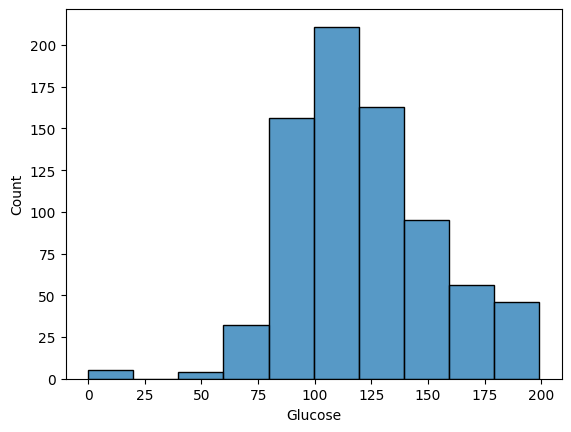

In [23]:
import seaborn as sns

sns.histplot(df['Glucose'], bins=10)

In [24]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Pregnancies는 출산 횟수를 의미하므로 제외

# 전체 데이터 건수
total_count = df['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
  zero_count = df[df[feature] == 0][feature].count()
  total_count = df[feature].count()
  print('{0} 0 건수는  {1}, 퍼센트는 {2:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))

# SkinThickness 와 lnsulin의  0값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체

Glucose 0 건수는  5, 퍼센트는 0.65%
BloodPressure 0 건수는  35, 퍼센트는 4.56%
SkinThickness 0 건수는  227, 퍼센트는 29.56%
Insulin 0 건수는  374, 퍼센트는 48.70%
BMI 0 건수는  11, 퍼센트는 1.43%


In [26]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균값으로 대체
df[zero_features] =df[zero_features].replace(0, df[zero_features].mean())

In [27]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [43]:
# 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 하는 것이 좋으며
# 다시 학습/테스트 데이터 세트로 나누고 로지스틱 회귀를 적용, 성능 평가 지표를 확인

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

오차 행렬:
 [[86 14]
 [20 34]]
정확도: 0.7792, 정밀도: 0.7083, 재현율: 0.6296, F1: 0.6667, AUC: 0.8407


In [44]:
precision_recall_curve_plot(y_test, pred_proba)
# 임곗값을 0.42로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것 같으니
# 모두 0.7이 안되는 낮은 수치를 보임

ValueError: y should be a 1d array, got an array of shape () instead.

In [40]:
# 임곗값에 따른 평가 수치 출력 함수
from sklearn.preprocessing import Binarizer
pred_proba_c1 = pred_proba.reshape(-1,1)
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  # thresholds  리스트 객체내의 값을 차례로 iteration 하면서 Evalution 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print("임곗값:",custom_threshold)
    get_clf_eval(y_test, custom_predict, pred_proba_c1)
    print()

In [41]:
# 임곗값은 0.3에서 0.5까지 변화시키면서 평가 지표 확인
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
get_eval_by_threshold(y_test, pred_proba_c1, thresholds)

임곗값: 0.3
오차 행렬:
 [[71 29]
 [ 9 45]]
정확도: 0.7532, 정밀도: 0.6081, 재현율: 0.8333, F1: 0.7031, AUC: 0.8407

임곗값: 0.33
오차 행렬:
 [[74 26]
 [14 40]]
정확도: 0.7403, 정밀도: 0.6061, 재현율: 0.7407, F1: 0.6667, AUC: 0.8407

임곗값: 0.36
오차 행렬:
 [[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1: 0.6667, AUC: 0.8407

임곗값: 0.39
오차 행렬:
 [[79 21]
 [15 39]]
정확도: 0.7662, 정밀도: 0.6500, 재현율: 0.7222, F1: 0.6842, AUC: 0.8407

임곗값: 0.42
오차 행렬:
 [[80 20]
 [16 38]]
정확도: 0.7662, 정밀도: 0.6552, 재현율: 0.7037, F1: 0.6786, AUC: 0.8407

임곗값: 0.45
오차 행렬:
 [[83 17]
 [17 37]]
정확도: 0.7792, 정밀도: 0.6852, 재현율: 0.6852, F1: 0.6852, AUC: 0.8407

임곗값: 0.48
오차 행렬:
 [[85 15]
 [19 35]]
정확도: 0.7792, 정밀도: 0.7000, 재현율: 0.6481, F1: 0.6731, AUC: 0.8407

임곗값: 0.5
오차 행렬:
 [[86 14]
 [20 34]]
정확도: 0.7792, 정밀도: 0.7083, 재현율: 0.6296, F1: 0.6667, AUC: 0.8407



임계값을 변경하면 재현율(Recall)과 정밀도(Precision)가 변화하지만 AUC(Area Under the Curve)는 동일하게 유지되는 이유는 AUC가 임계값의 변화에 무관한 평가 지표이기 때문이다.

- 재현율과 정밀도의 변화: 임계값을 변경하면 분류기가 어떤 예측을 '긍정' 또는 '부정'으로 분류할지 기준이 바뀌며 이에 따라 True Positive, False Positive, True Negative, False Negative의 수가 변하게 되며 이는 재현율과 정밀도를 직접적으로 영향을 미친다.

- AUC의 불변성: AUC는 ROC(Receiver Operating Characteristic) 곡선 아래의 면적을 의미. ROC 곡선은 모든 가능한 임계값에 대해 True Positive Rate(TPR, 재현율)과 False Positive Rate(FPR)을 플롯한 것이다. AUC는 이 곡선 아래의 전체 면적을 측정하는 것이므로, 특정 임계값에서의 성능 변화보다는 분류기의 전반적인 성능을 평가. 이 때문에 임계값이 변해도 AUC 값은 동일하게 유지된다.

- 결론적으로, 재현율과 정밀도는 특정 임계값에서의 성능을 나타내는 반면, AUC는 분류기의 전체적인 성능을 종합적으로 평가하는 지표로, 임계값의 변화에 영향을 받지 않는다.

lr_clf.predict_proba(X_test)[:,1]: 이 코드는 모델이 예측한 각 샘플이 긍정 클래스(1 클래스)에 속할 확률을 1차원 배열로 반환합니다. roc_auc_score 함수는 1차원 배열 형태의 입력을 받을 수 있기 때문에 이 형태로 사용하는 것이 적절합니다.

lr_clf.predict_proba(X_test)[:,1].reshape(-1,1): 이 코드는 동일한 예측 확률을 2차원 배열(열 벡터) 형태로 변환합니다. 일반적으로 roc_auc_score 함수에는 1차원 배열을 입력으로 제공하는 것이 일반적이므로, 이 형태는 필요하지 않습니다.